# Homework 2
## IDS 576 <br>
Name: Isaac Salvador <br>
Email: isalva2@uic.edu <br>
UIN: 6669845132 <br>

Name: Ahreum Kim <br>
Email: akim239@uic.edu <br>
UIN: 653241895 <br>

please add your information here

## 1. CNNs and finetuning


### Download the CIFAR 10 dataset (original data can be found [here](http://www.cs.toronto.edu/~kriz/cifar.html), and here is a link to the  pickled [python version](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).)

Keras has a version of _CIFAR 10_ available for easy download:

In [49]:
# download CIFAR 10 dataset from keras
import numpy as np
from keras.datasets import cifar10
 
# load CIFAR 10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# from the keras website we can load the label descriptions
y_description = ["airplane",
                 "automobile",
                 "bird",
                 "cat",
                 "deer",
                 "dog",
                 "frog",
                 "horse",
                 "ship",
                 "truck"]


We next observe the shape of the dataset and display some example instances

Training Data Shape: (50000, 32, 32, 3)
Testing Data Shape: (10000, 32, 32, 3)


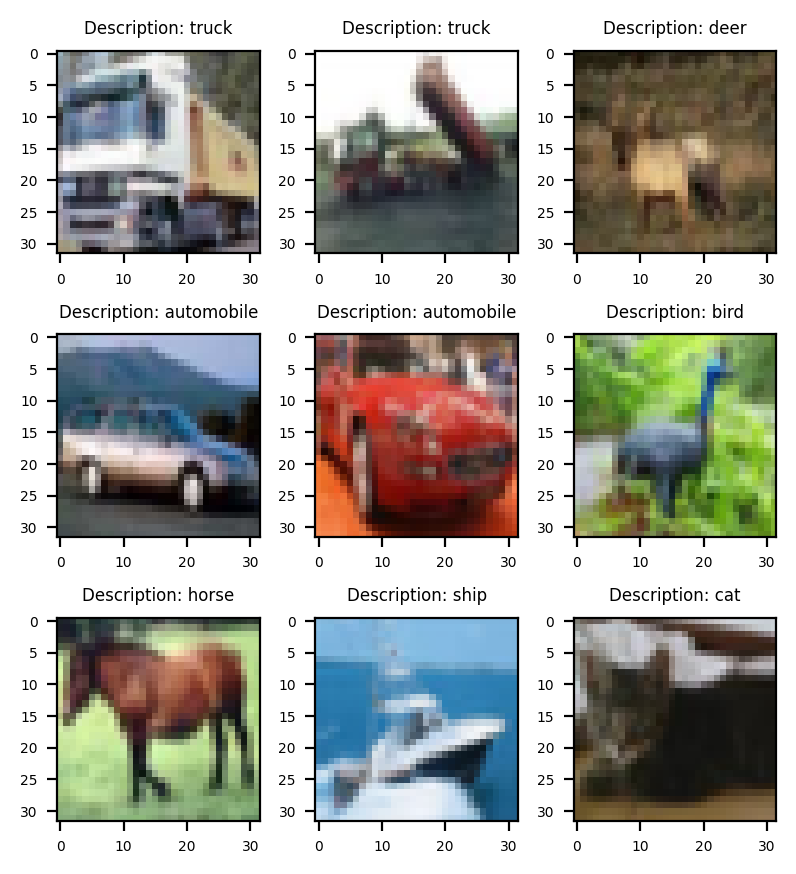

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 5})

# obtain data summary
plt.figure(figsize=(5, 5), dpi=200)

for i in range(1,10):

    plt.subplot(3,3,i,)
    plt.title("Description: "+y_description[y_train[i][0]])

    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))

plt.subplots_adjust(wspace=0, hspace=0.4)

print(f"Training Data Shape: {X_train.shape}\n"+
      f"Testing Data Shape: {X_test.shape}")

To train our `torch` model we will create a custom `CIFAR10_Dataset` class that accepts `torchvision.transforms` and will subsequently used in a `torch.utils.data.DataLoader`.

The PyTorch website has some [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) regarding the creation of a custom dataset.

In [59]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# create custom dataset that inherits from the torch Dataset class
class CIFAR10_Dataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y
        self.transform = transform

    '''
    Per PyTorch documentation this custom clas must
    implement the __len__ and __getitem__ methods.
    '''

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        img = Image.fromarray(self.X[index])
        label = self.y[index]

        if self.transform:
            img = self.transform(img)

        return img, label

Use the pretrained Resnet18 model (from trochvision) to extract features. Use the features as inputs in a new multi-class logistic regression model (use nn.Linear/ nn.Module to define your model)
	 -(a) Describe any choices made and report test performance.
	 -(b) Display the top 5 correct predictions and the top 5 incorrect predictions in each class (show the images and the prediction labels) compactly.

Finetune the Resnet18 model's parameters suitably and repeat parts (a) and (b) from above. Compare the performance of finetuning versus using extracted features.

## 2. Movie embeddings


Instead of embedding words, we will embed movies.  In particular, if we can embed movies, then similar movies will be close to each other and can be recommended.  This line of reasoning  is analogous to the [distributional hypothesis of word meanings](https://en.wikipedia.org/wiki/Distributional_semantics). For words, this roughly translates to words that appear in similar sentences should have similar vector representations. For movies, vectors for two movies should be similar if they are watched by similar people.

Let the total number of movies be $M$. Let $X_{i,j}$ be the number of users that liked both movies $i$ and $j$. We want to obtain vectors $v_1,...,v_i,...,v_j,...,v_M$ for all movies such that we minimize the cost $c(v_1,...,v_M) = \sum_{i=1}^{M}\sum_{j=1}^{M}\mathbf{1}_{[i\neq j]}(v_i^Tv_j - X_{i,j})^2$. Here $\mathbf{1}_{[i\neq j]}$ is a function that is $0$ when $i=j$ and $1$ otherwise.

Compute data $X_{i,j}$ from the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip). You can also download using the link to `ml-latest-small.zip` from this [page](https://grouplens.org/datasets/movielens/) (be sure to read the corresponding [description](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)). Briefly describe your data prep workflow (you can use `pandas` if needed).

Optimize function $c(v_1,...,v_M)$ over $v_1,...,v_M$ using gradient descent (using `pytorch` or `tensorflow`). Plot the loss as a function of iteration for various choices (learning rates, choice of optimizers etc).

Recommend top 10 movies (not vectors or indices but movie names) given movies (a) _Apollo 13_, (b) _Toy Story_, and (c) _Home Alone_ . Describe your recommendation strategy. Do the recommendations change when you change learning rates or optimizers? Why or why not?